Processed output_0: Uncertainty 1 mean=3.4874872026842763, Uncertainty 2 mean=440740.8373072441, Uncertainty 3 mean=3.4874872026842763
Processed output_1: Uncertainty 1 mean=2.9408691101348725, Uncertainty 2 mean=nan, Uncertainty 3 mean=2.9408691101348725
Processed output_2: Uncertainty 1 mean=0.5086278184196034, Uncertainty 2 mean=261579.68120605752, Uncertainty 3 mean=0.5086278184196034
Processed output_3: Uncertainty 1 mean=1.7106974316812051, Uncertainty 2 mean=nan, Uncertainty 3 mean=1.7106974316812051
Processed output_4: Uncertainty 1 mean=2.9388315302658437, Uncertainty 2 mean=297283.3047367446, Uncertainty 3 mean=2.9388315302658437
Processed output_5: Uncertainty 1 mean=2.447403546500285, Uncertainty 2 mean=300236.8373822081, Uncertainty 3 mean=2.447403546500285
Processed output_6: Uncertainty 1 mean=11.142376824069881, Uncertainty 2 mean=680149.3092753786, Uncertainty 3 mean=11.142376824069881
Processed output_7: Uncertainty 1 mean=3.7903338884262165, Uncertainty 2 mean=949966

/var/folders/q0/wvzwk03s5wqdmltmy25q2btr0000gn/T/ipykernel_10743/1091053464.py:12: RuntimeWarning: invalid value encountered in sqrt
  uncertainties = np.sqrt(np.diag(cov_matrix))  # Extract the square root of the diagonal elements of the covariance matrix as uncertainties


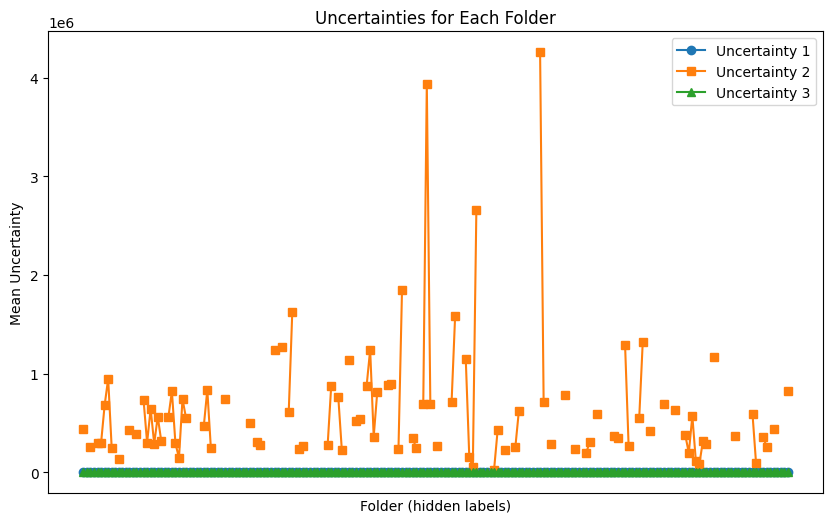

Uncertainty Summary Statistics:
       mean_uncertainty_1  mean_uncertainty_2  mean_uncertainty_3
count          200.000000        9.900000e+01          200.000000
mean            12.255113        6.433485e+05           12.255113
std             23.672579        6.551240e+05           23.672579
min              0.316079        2.828899e+04            0.316079
25%              1.982336        2.822026e+05            1.982336
50%              3.054493        4.407408e+05            3.054493
75%              8.339600        7.549024e+05            8.339600
max            135.458686        4.256457e+06          135.458686
Uncertainty results saved to fisher_uncertainties.csv


In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import pickle

# Calculate covariance matrix and extract uncertainties
def compute_uncertainties(fisher_matrix):
    try:
        cov_matrix = np.linalg.inv(fisher_matrix)  # Directly invert to get the covariance matrix
        uncertainties = np.sqrt(np.diag(cov_matrix))  # Extract the square root of the diagonal elements of the covariance matrix as uncertainties
        return uncertainties
    except np.linalg.LinAlgError:
        print("Matrix is singular and cannot be inverted.")
        return np.nan * np.ones(fisher_matrix.shape[0])

# Process all folders and extract uncertainties
def process_all_folders(base_dir):
    results = []
    
    for i in range(200):  # Limit the range to 0 to 199
        folder_path = os.path.join(base_dir, f'output_{i}', 'R_ET_1_ET_2_ET_3')
        pkl_file_path = os.path.join(folder_path, 'R_ET_1_ET_2_ET_3_0.pkl')
        
        if not os.path.exists(pkl_file_path):
            print(f"File {pkl_file_path} not found, skipping.")
            continue
        
        with open(pkl_file_path, 'rb') as file:
            data = pickle.load(file)  # Use pickle to read the file

        fisher_matrix_1 = data[1]
        fisher_matrix_2 = data[2][0]
        fisher_matrix_3 = data[2][1]

        # Directly invert and calculate uncertainties
        uncertainties_1 = compute_uncertainties(fisher_matrix_1)
        uncertainties_2 = compute_uncertainties(fisher_matrix_2)
        uncertainties_3 = compute_uncertainties(fisher_matrix_3)

        results.append({
            'folder': f'output_{i}',
            'uncertainties_1': uncertainties_1,
            'uncertainties_2': uncertainties_2,
            'uncertainties_3': uncertainties_3
        })
        
        print(f"Processed output_{i}: Uncertainty 1 mean={np.mean(uncertainties_1)}, Uncertainty 2 mean={np.mean(uncertainties_2)}, Uncertainty 3 mean={np.mean(uncertainties_3)}")
    
    return results

# Save results to a CSV file
def save_results_to_csv(results, output_file):
    with open(output_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['folder', 'uncertainties_1', 'uncertainties_2', 'uncertainties_3'])
        for result in results:
            writer.writerow([result['folder'], ','.join(map(str, result['uncertainties_1'])), ','.join(map(str, result['uncertainties_2'])), ','.join(map(str, result['uncertainties_3']))])

# Read CSV and visualize
def visualize_uncertainties(csv_file):
    data = pd.read_csv(csv_file)
    
    # Convert uncertainty strings separated by commas into numeric values
    def convert_to_numeric_list(uncertainty_str):
        return list(map(float, uncertainty_str.split(',')))
    
    data['uncertainties_1'] = data['uncertainties_1'].apply(convert_to_numeric_list)
    data['uncertainties_2'] = data['uncertainties_2'].apply(convert_to_numeric_list)
    data['uncertainties_3'] = data['uncertainties_3'].apply(convert_to_numeric_list)
    
    # Calculate the mean uncertainty for each folder
    data['mean_uncertainty_1'] = data['uncertainties_1'].apply(np.mean)
    data['mean_uncertainty_2'] = data['uncertainties_2'].apply(np.mean)
    data['mean_uncertainty_3'] = data['uncertainties_3'].apply(np.mean)
    
    # Plot the comparison of uncertainties
    plt.figure(figsize=(10, 6))
    plt.plot(data['folder'], data['mean_uncertainty_1'], label='Uncertainty 1', marker='o')
    plt.plot(data['folder'], data['mean_uncertainty_2'], label='Uncertainty 2', marker='s')
    plt.plot(data['folder'], data['mean_uncertainty_3'], label='Uncertainty 3', marker='^')
    
    # Hide x-axis labels
    plt.xticks([])

    plt.title('Uncertainties for Each Folder')
    plt.xlabel('Folder (hidden labels)')
    plt.ylabel('Mean Uncertainty')
    plt.legend(loc='upper right')
    plt.show()
    
    # Compute summary statistics for uncertainties
    summary_stats = data[['mean_uncertainty_1', 'mean_uncertainty_2', 'mean_uncertainty_3']].describe()

    print("Uncertainty Summary Statistics:")
    print(summary_stats)

# Main program
if __name__ == "__main__":
    base_dir = "/Users/ciel/ET/KL_test_200Mpc"
    output_file = "fisher_uncertainties.csv"
    
    # Process all folders and save results
    results = process_all_folders(base_dir)
    save_results_to_csv(results, output_file)
    
    # Read the saved file and perform visual analysis
    visualize_uncertainties(output_file)
    
    print(f"Uncertainty results saved to {output_file}")